In [739]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# import tensorflow as tf
# from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense
from sklearn import preprocessing

from sklearn.model_selection import *
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
import seaborn as sns
from scipy import stats

## **Exploratory Data Analysis**

In [770]:
data = pickle.load(open(r'../Data/deltaQ_cycles.pkl', 'rb'))
data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

In [771]:
y = np.zeros(124)

x = np.zeros((124, 40))
for i, cell in enumerate(data.keys()):
    x[i, :] = data[cell]["DeltaQ_logVars"][9:]
    # x[i, :, 1] = np.log10(-data[cell]["DeltaQ_mins"][9:])
    # x[i, :] = data[cell]["DeltaQ_means"][9:]
    # x[i, :, 2] = data2[cell]["DeltaT_var"][9:]
    # x[i, :, 3] = data2[cell]["Delta_Tmax"][9:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [772]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])


In [773]:
class AutoEncoder_ElasticNet(nn.Module):
    def __init__(self, n_features, n_cycles=49, alpha=0.5, en_lambda = 0.1, lr = 1e-3, epochs = 500):
        super(AutoEncoder_ElasticNet, self).__init__()

        self.alpha = alpha
        self.n_features = n_features
        self.en_lambda = en_lambda
        self.lr = lr
        self.epochs = epochs

        self.encoder = nn.Sequential(
            nn.Linear(n_features*n_cycles, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*16),
            # nn.ReLU(),
            # nn.Linear(n_features*16, n_features*8),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            # nn.Linear(n_features*8, n_features*16),
            # nn.ReLU(),
            nn.Linear(n_features*16, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*n_cycles)
        )

        self.prediction = nn.Linear(n_features*16, 1)

    def elastic_net_loss(self):

        l1_norm = self.prediction.weight.abs().sum()
        l2_norm = self.prediction.weight.pow(2).sum()

        return (1-self.alpha)/2 * l2_norm + self.alpha * l1_norm
    
    def elastic_net_predict(self, x):
        return self.prediction(self.encoder(x))
    
    def forward(self, x):
        self.eval()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X, y):
        optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        loss_function = nn.MSELoss()
        for ep in range(self.epochs):
            optimiser.zero_grad()


            outputs = self.forward(X)
            predictions = self.elastic_net_predict(X)

            loss = loss_function(y, predictions) + loss_function(X, outputs)


            loss += self.elastic_net_loss()*self.en_lambda
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")

In [774]:
del model
model = AutoEncoder_ElasticNet(n_features=1, n_cycles=40, lr = 1e-4, en_lambda=0.5)
model.fit(x[train_ind], y[train_ind])

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([41, 1])) that is different to the input size (torch.Size([41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/500, loss: 29.82
Epoch 50/500, loss: 25.61
Epoch 100/500, loss: 23.32
Epoch 150/500, loss: 20.34
Epoch 200/500, loss: 16.01
Epoch 250/500, loss: 11.29
Epoch 300/500, loss: 7.21
Epoch 350/500, loss: 4.09
Epoch 400/500, loss: 2.32
Epoch 450/500, loss: 1.51


In [775]:
model.encoder(x[5])

tensor([0.0000, 0.0000, 0.0000, 4.8282, 2.9539, 0.0000, 4.8345, 0.0370, 0.5765,
        0.0000, 0.0000, 0.0000, 3.7787, 9.9836, 3.0654, 3.2527],
       grad_fn=<ReluBackward0>)

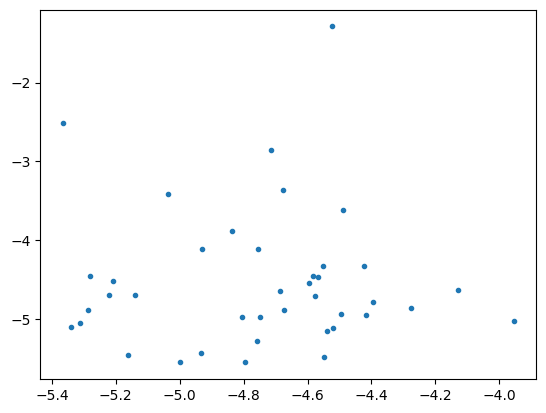

In [776]:
plt.plot(x[4].detach().numpy(), model.forward(x[4]).detach().numpy(), ".")

In [777]:
print(y[1], model.elastic_net_predict(x[1]))


[CV] END ..............alpha=0.29298587592451836, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.29298587592451836, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.29298587592451836, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.29298587592451836, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.29366134574676506, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.29366134574676506, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.29366134574676506, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.29366134574676506, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3809413230471342, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3809413230471342, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3809413230471342, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3809413230471342, l1_ratio=1; total time=   0.0s
[CV] END ..............alph

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.463e-04, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e-03, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

0706297, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=2.4885111670706297, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.228129102217385, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.228129102217385, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.228129102217385, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.228129102217385, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.2355714534364792, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.2355714534364792, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.2355714534364792, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.2355714534364792, l1_ratio=1; total time=   0.0s
[CV] END .................alpha=3.24303096276478, l1_ratio=1; total time=   0.0s
[CV] END .................alpha=3.24303096276478, l1_ratio=1; total time=   0.0s
[CV] END .................alpha=3.24303096276478, l1_ratio=1; total t

regularisation. Duality gap: 2.854e-04, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e-04, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e-04, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You 

ratio=1; total time=   0.0s
[CV] END ................alpha=5.874581018442146, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.888124682223821, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.888124682223821, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.888124682223821, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.888124682223821, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.901699570501005, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.901699570501005, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.901699570501005, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=5.901699570501005, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=5.9153057552608015, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=5.9153057552608015, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=5.9153057552608015, l1_ratio=1; total time=   0.0s


 of the features or consider increasing regularisation. Duality gap: 9.039e-05, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e-04, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.564e-05, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceW


[CV] END ...............alpha=0.5481177766181939, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.5481177766181939, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.5481177766181939, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.5493814451004178, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.5493814451004178, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.5493814451004178, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.5493814451004178, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.6620367350460422, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.6620367350460422, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.6620367350460422, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.6620367350460422, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=0.663563040142939, l1_ratio=1; total time=   0.0s
[CV] END ................al

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e-03, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e-04, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

atio=1; total time=   0.0s
[CV] END ...............alpha=4.0640673462238714, l1_ratio=1; total time=   0.0s
[CV] END .................alpha=4.07343692705875, l1_ratio=1; total time=   0.0s
[CV] END .................alpha=4.07343692705875, l1_ratio=1; total time=   0.0s
[CV] END .................alpha=4.07343692705875, l1_ratio=1; total time=   0.0s
[CV] END .................alpha=4.07343692705875, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=4.082828109170743, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=4.082828109170743, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=4.082828109170743, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=4.082828109170743, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=4.092240942360954, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=4.092240942360954, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=4.092240942360954, l1_ratio=1; total time=   0.0s
[

n3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.039e-05, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.786e-04, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e-04, 

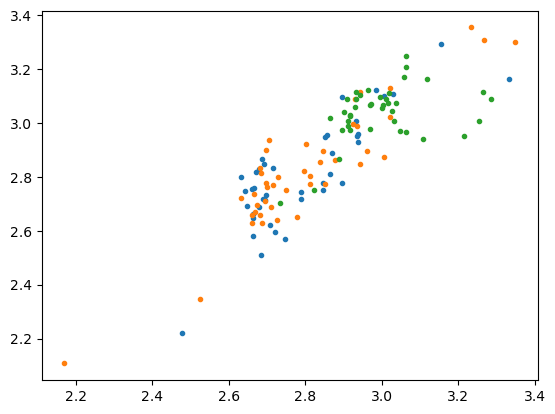

In [778]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")

In [779]:
x_train = reduced_df[train_ind,:]  # Remove the target column from the features
y_train = Y[train_ind]

x_test = reduced_df[test_ind,:]  # Remove the target column from the features
y_test = Y[test_ind]

x_stest = reduced_df[secondary_ind,:]  # Remove the target column from the features
y_stest = Y[secondary_ind]


[CV] END ..............alpha=0.28238725026890366, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.28238725026890366, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2830382852894212, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2830382852894212, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2830382852894212, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2830382852894212, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.36716095064184007, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.36716095064184007, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.36716095064184007, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.36716095064184007, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3680074287912832, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3680074287912832, l1_ratio=1; total time=   0.0s
[CV] END ...............alp

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-04, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-04, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


[CV] END ................alpha=3.605418605681514, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.605418605681514, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.605418605681514, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.605418605681514, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.6137307861134738, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.6137307861134738, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.6137307861134738, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=3.6137307861134738, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.622062130018845, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.622062130018845, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.622062130018845, l1_ratio=1; total time=   0.0s
[CV] END ................alpha=3.622062130018845, l1_ratio=1; total time=   0.0s
[CV] END ................al

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e-04, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-03, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


[CV] END ..............alpha=0.33872947210811327, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.33872947210811327, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.33872947210811327, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3395104023682912, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3395104023682912, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3395104023682912, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3395104023682912, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.34029313303889086, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.34029313303889086, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.34029313303889086, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.34029313303889086, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.4414326849658849, l1_ratio=1; total time=   0.0s
[CV] END ...............alp

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.221e-04, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.117e-04, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


[CV] END ...............alpha=0.3646331805309412, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3654738309850332, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3654738309850332, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3654738309850332, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3654738309850332, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3663164195325948, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3663164195325948, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3663164195325948, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.3663164195325948, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.4751904311947496, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.4751904311947496, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.4751904311947496, l1_ratio=1; total time=   0.0s
[CV] END ...............alp

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e-03, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e-04, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

## **ElasticNet Model**

In [780]:
def loss(ground_truth, predictions):
    diff = np.sqrt(np.mean((10**ground_truth - 10**predictions)**2))
    return diff

my_scorer = make_scorer(loss, greater_is_better=False)

regressor = ElasticNet(max_iter=1000)
param_grid = {
    'alpha': np.logspace(-9, 1, 10000),  # Range of alpha values to explore
    'l1_ratio': [1]
}
print(y_train)
folds = KFold(n_splits=4, shuffle=True, random_state=42)
model = RandomizedSearchCV(
    estimator=regressor,
    n_iter=10000,
    cv=folds,
    param_distributions=param_grid,
    scoring=my_scorer,
    random_state=42,
    verbose=2,
    return_train_score=True,
    n_jobs=-1
)
print(model)
model.fit(x_train, (y_train))

b1c1     3.334454
b1c3     3.156549
b1c5     3.031004
b1c7     2.939519
b1c11    2.896526
b1c15    2.856729
b1c17    2.932981
b1c19    2.896526
b1c21    2.747412
b1c24    3.007321
b1c26    2.939519
b1c28    2.934498
b1c30    2.850646
b1c32    2.863917
b1c34    2.870404
b1c36    2.847573
b1c38    2.790285
b1c40    2.984977
b1c42    2.846337
b1c44    2.789581
b2c0     2.477121
b2c2     2.641474
b2c4     2.647383
b2c6     2.708421
b2c11    2.678518
b2c13    2.683947
b2c17    2.693727
b2c19    2.663701
b2c21    2.689309
b2c23    2.721811
b2c25    2.663701
b2c27    2.670246
b2c29    2.697229
b2c31    2.691965
b2c33    2.716003
b2c35    2.665581
b2c37    2.679428
b2c39    2.661813
b2c41    2.632457
b2c43    2.664642
b2c45    2.687529
Name: cycle_life, dtype: float64
RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=ElasticNet(), n_iter=10000, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-09, 1.00230547e-09, 1

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.908e-02, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.280e-02, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.227e-02, tolerance: 8.440e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.907e-02, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.565e-02, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.034e-02, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.065e-02, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.974e-02, tolerance: 8.440e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.994e-02, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.837e-02, tolerance: 8.440e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.488e-02, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.127e-02, tolerance: 8.440e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.215e-02, tolerance: 8.440e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.201e-02, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.040e-02, tolerance: 8.440e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.761e-02, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

[CV] END ...........alpha=1.0023054688903187e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0046162529674373e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0092538157263383e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0185932645581735e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0185932645581735e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0209415996414963e-09, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.023295348738302e-09, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.023295348738302e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0280191389284841e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0280191389284841e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0327647353291453e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.0327647353291453e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.977e-02, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.442e-02, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

] END ...........alpha=1.2823624751348818e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2823624751348818e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2823624751348818e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2823624751348818e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2853189219274173e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2853189219274173e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2853189219274173e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2853189219274173e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2882821847160588e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2882821847160588e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2882821847160588e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.2882821847160588e-09, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.291

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.209e-02, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e-02, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

4234836997498e-09, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.185362695317771e-09, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.185362695317771e-09, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.185362695317771e-09, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.185362695317771e-09, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.148433918201545e-08, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.148433918201545e-08, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.148433918201545e-08, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.148433918201545e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1510815968725455e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1510815968725455e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1510815968725455e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1510815968725455e-08, l1_ratio=

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-02, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e-02, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.281e-03, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e-02, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e-03, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e-03, tolerance: 6.289e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.735e-03, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.104e-04, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


[CV] END ...........alpha=2.2188840761992103e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.2188840761992103e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.2239996444081108e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.2239996444081108e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.2239996444081108e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.2239996444081108e-08, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=2.885001309391822e-08, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=2.885001309391822e-08, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=2.885001309391822e-08, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=2.885001309391822e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.8916525901591475e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.8916525901591475e-08, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-03, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.048e-04, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

91983e-07, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=4.4798670600691983e-07, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=4.4798670600691983e-07, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=4.4798670600691983e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.490195254208942e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.490195254208942e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.490195254208942e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.490195254208942e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.500547259678968e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.500547259678968e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.500547259678968e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=4.500547259678968e-07, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=4.5109231313755664e-07, l1_ratio=1; total

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.523e-03, tolerance: 7.489e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e-04, tolerance: 9.600e-05
  model = cd_fast.enet_coordinate_descent(
/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


[CV] END ............alpha=5.905778136518516e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=5.905778136518516e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.661052329605027e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.661052329605027e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.661052329605027e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.661052329605027e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.678714647418019e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.678714647418019e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.678714647418019e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=7.678714647418019e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=7.69641768515526e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=7.69641768515526e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha

[CV] END ............alpha=8.959736334752305e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=8.959736334752305e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=8.959736334752305e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=8.959736334752305e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=8.980392728137516e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=8.980392728137516e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=8.980392728137516e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=8.980392728137516e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=9.00109674419508e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=9.00109674419508e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=9.00109674419508e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=9.00109674419508e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9

[CV] END ...........alpha=1.1703259386784595e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1730240887216134e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1730240887216134e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1730240887216134e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1730240887216134e-06, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.175728459265753e-06, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.175728459265753e-06, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.175728459265753e-06, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.175728459265753e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1784390646520524e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1784390646520524e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.1784390646520524e-06, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.

[CV] END .............alpha=9.66715161364106e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=9.66715161364106e-07, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=9.66715161364106e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.689438930944302e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.689438930944302e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.689438930944302e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.689438930944302e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.711777630964237e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.711777630964237e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.711777630964237e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.711777630964237e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9.734167832162097e-07, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=9

[CV] END ...........alpha=2.3465890712500454e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7636997057978967e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7636997057978967e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7636997057978967e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7636997057978967e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7677658606014744e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7677658606014744e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7677658606014744e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7677658606014744e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7718413897984583e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7718413897984583e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.7718413897984583e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=1.

[CV] END .............alpha=5.05208148920104e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=5.05208148920104e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=5.05208148920104e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=5.05208148920104e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=5.0637289059057374e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=5.0637289059057374e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=5.0637289059057374e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=5.0637289059057374e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=5.07540317536731e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=5.07540317536731e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=5.07540317536731e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=5.07540317536731e-05, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=5

[CV] END ...........alpha=0.00047815418009483895, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.997239023402302e-05, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=1.997239023402302e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0018435958372864e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0018435958372864e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0018435958372864e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0018435958372864e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0064587839707686e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0064587839707686e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0064587839707686e-05, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=2.0064587839707686e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=2.01108461227692e-05, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=

[CV] END ............alpha=0.0002515011956208049, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0002515011956208049, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0002515011956208049, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00025208102380318656, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00025208102380318656, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00025208102380318656, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00025208102380318656, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.000252662188761404, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.000252662188761404, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.000252662188761404, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.000252662188761404, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0002532446935773527, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0

[CV] END ............alpha=0.0008120653109442142, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00042321656335135826, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00042321656335135826, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00042321656335135826, l1_ratio=1; total time=   0.0s
[CV] END ...........alpha=0.00042321656335135826, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0004241922759720315, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0004241922759720315, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0004241922759720315, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0004241922759720315, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0004251702380677985, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0004251702380677985, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0004251702380677985, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0

[CV] END ............alpha=0.0025801274789462795, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0025860758825820463, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0025860758825820463, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0025860758825820463, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0025860758825820463, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.002592038000077337, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.002592038000077337, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.002592038000077337, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.002592038000077337, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.002598013863049039, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.002598013863049039, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.002598013863049039, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=

[CV] END ............alpha=0.0006738804516813187, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006754340620984626, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006754340620984626, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006754340620984626, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006754340620984626, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006769912543160907, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006769912543160907, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006769912543160907, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006769912543160907, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006785520365919343, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006785520365919343, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0.0006785520365919343, l1_ratio=1; total time=   0.0s
[CV] END ............alpha=0

[CV] END .............alpha=0.020124744392682782, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010488226803202064, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010488226803202064, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010512407083811452, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010512407083811452, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010512407083811452, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010512407083811452, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010536643111305524, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010536643111305524, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010536643111305524, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010536643111305524, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=0.010560935014207008, l1_ratio=1; total time=   0.0s
[CV] END .............alpha=

[CV] END ..............alpha=0.24936740389335982, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.24936740389335982, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.24936740389335982, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.24936740389335982, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2499423126852955, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2499423126852955, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2499423126852955, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2499423126852955, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2505185469115657, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2505185469115657, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2505185469115657, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.2505185469115657, l1_ratio=1; total time=   0.0s
[CV] END ...............alph

[CV] END ..............alpha=0.11770829817060216, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.11770829817060216, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.11797967099016635, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.11797967099016635, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.11797967099016635, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.11797967099016635, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.1182516694513242, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.1182516694513242, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.1182516694513242, l1_ratio=1; total time=   0.0s
[CV] END ...............alpha=0.1182516694513242, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.11852429499647248, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha=0.11852429499647248, l1_ratio=1; total time=   0.0s
[CV] END ..............alpha

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.995e-02, tolerance: 1.070e-04
  model = cd_fast.enet_coordinate_descent(


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=ElasticNet(), n_iter=10000, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-09, 1.00230547e-09, 1.00461625e-09, ...,
       9.95404959e+00, 9.97699834e+00, 1.00000000e+01]),
                                        'l1_ratio': [1]},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(loss, greater_is_better=False),
                   verbose=2)

In [781]:
regressor = ElasticNet(l1_ratio=model.best_params_["l1_ratio"], alpha=model.best_params_['alpha'])
regressor.fit(x_train,y_train)

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.995e-02, tolerance: 1.070e-04
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=2.5242956216793446e-08, l1_ratio=1)

In [782]:
print("RMSE on Train Data: ", np.sqrt(np.mean( (np.power(10,regressor.predict(x_train))-
                                                np.power(10,y_train))**2) ))
print("RMSE on Test Data: ", np.sqrt(np.mean( (np.power(10,regressor.predict(x_test))-
                                                np.power(10,y_test))**2) ))
print("RMSE on Secondary Test Data: ", np.sqrt(np.mean( (np.power(10,regressor.predict(x_stest))-
                                                np.power(10,y_stest))**2) ))

RMSE on Train Data:  129.7461610303217
RMSE on Test Data:  144.70774509915273
RMSE on Secondary Test Data:  348.54496136593224


In [783]:
regressor.coef_

array([ 0.01428642, -0.0313834 ,  0.02839188], dtype=float32)

# SVR

In [784]:
def select_indices(arr):
    return arr[select]
select = np.array([0,1,2])
x_t = x_train[:,select]
x_te = x_test[:,select]
x_ste = x_stest[:,select]

In [785]:
scaler = preprocessing.StandardScaler().fit(list(x_t))
x_t = scaler.transform(list(x_t))
x_te = scaler.transform(list(x_te))
x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y_train))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y_test))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y_stest))

In [786]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, vdim=1, num_heads=1):
        super(AttentionModel, self).__init__()

        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.d_model = d_model

    def reshape_input(self,X):
        return X.reshape(X.shape[0], -1)

    def scaled_dot_product_attention(self, Q, K, V):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
    
    def forward(self, X):
        X = self.reshape_input(X)
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        attn_output = self.scaled_dot_product_attention(Q, K, V)
        return attn_output

In [793]:
# parameters
lr = 0.01
feat_dim = 3
d_model = 2
nepoch = 500
batch_size = 1

In [794]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [795]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  500.464 | rmse_test:  693.450 | rmse_stest:  769.619
Epochs: 100 | rmse:  140.214 | rmse_test:  118.457 | rmse_stest:  276.924
Epochs: 150 | rmse:  181.789 | rmse_test:  242.496 | rmse_stest:  263.615
Epochs: 200 | rmse:  135.730 | rmse_test:  127.680 | rmse_stest:  306.770
Epochs: 250 | rmse:  130.533 | rmse_test:  148.449 | rmse_stest:  346.345
Epochs: 300 | rmse:  163.580 | rmse_test:  121.914 | rmse_stest:  269.363
Epochs: 350 | rmse:  139.718 | rmse_test:  124.957 | rmse_stest:  319.926
Epochs: 400 | rmse:  125.200 | rmse_test:  126.201 | rmse_stest:  305.293
Epochs: 450 | rmse:  134.646 | rmse_test:  161.142 | rmse_stest:  271.262
Epochs: 500 | rmse:  166.630 | rmse_test:  139.492 | rmse_stest:  259.378


In [796]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

In [ ]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)